## In this notebook, we will cover:
- [Overview](#0) \
<br/>
- [Importing Libraries](#1) \
<br/>
- [Loading Dataset](#2) \
<br/>
- [Exploratory Data Analysis (EDA)](#3) \
<br/>
- [Cross Validation](#4) \
<br/>
- [XGBoost](#5)

## Overview <a name="0"> </a>

PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

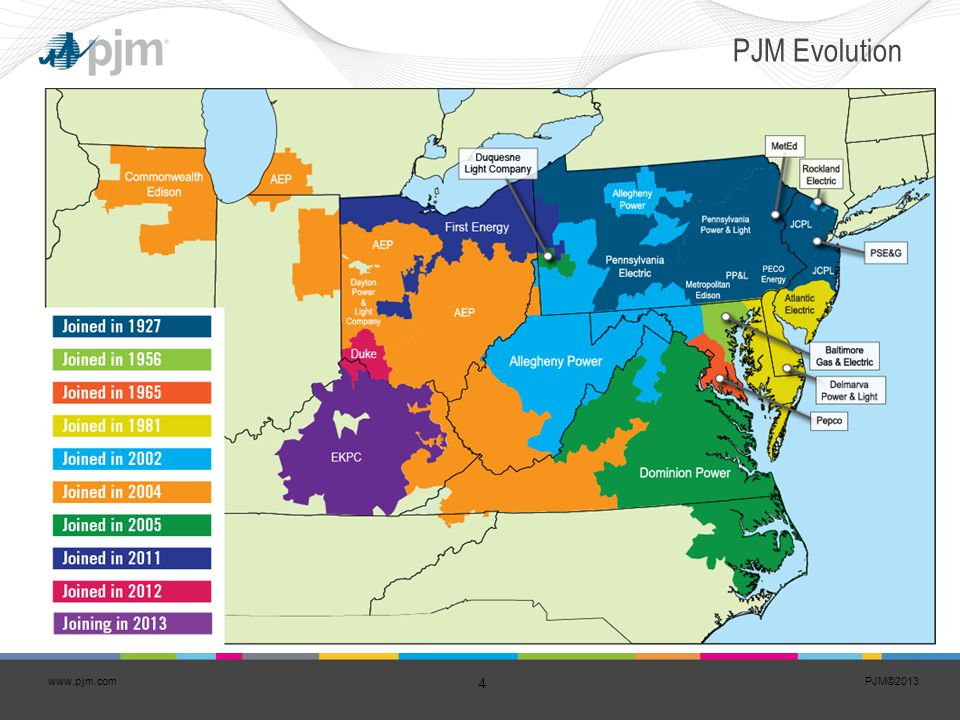

In [60]:
import requests
import IPython.display as Disp

url = 'http://slideplayer.com/4238181/14/images/4/PJM+Evolution.jpg'
Disp.Image(requests.get(url).content)

# Importing Libraries <a name="1"> </a>

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Loading Dataset <a name="2"> </a>

In [62]:
df = pd.read_csv('/Users/orestisvaggelis/Desktop/Projects/Εργασίες/Energy Consumption/archive/PJME_hourly.csv')

Sort by Datetime

In [63]:
sorted_df = df.sort_values(by='Datetime')
sorted_df = sorted_df.reset_index(drop=True)

In [64]:
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


Check for missing values

In [65]:
null_count = sorted_df.isnull().sum()
print(null_count)

Datetime    0
PJME_MW     0
dtype: int64


Check for duplicate rows

In [66]:
duplicate_rows = sorted_df[sorted_df.duplicated(subset=['Datetime'], keep=False)]
print(duplicate_rows)

                   Datetime  PJME_MW
112487  2014-11-02 02:00:00  23755.0
112488  2014-11-02 02:00:00  22935.0
121223  2015-11-01 02:00:00  21567.0
121224  2015-11-01 02:00:00  21171.0
130127  2016-11-06 02:00:00  20795.0
130128  2016-11-06 02:00:00  21692.0
138863  2017-11-05 02:00:00  21236.0
138864  2017-11-05 02:00:00  20666.0


In [67]:
number_of_duplicate_rows = sorted_df.duplicated('Datetime', keep=False).sum()
print("Total number of duplicate rows based on 'Datetime'")
print (number_of_duplicate_rows)

Total number of duplicate rows based on 'Datetime'
8


Handle the duplicate rows

In [68]:
print(sorted_df.iloc[112482:112494]) #print the previous 5 and next 5 values of the duplicates rows

                   Datetime  PJME_MW
112482  2014-11-01 21:00:00  29695.0
112483  2014-11-01 22:00:00  28829.0
112484  2014-11-01 23:00:00  27430.0
112485  2014-11-02 00:00:00  25838.0
112486  2014-11-02 01:00:00  23538.0
112487  2014-11-02 02:00:00  23755.0
112488  2014-11-02 02:00:00  22935.0
112489  2014-11-02 03:00:00  22789.0
112490  2014-11-02 04:00:00  22555.0
112491  2014-11-02 05:00:00  23247.0
112492  2014-11-02 06:00:00  23733.0
112493  2014-11-02 07:00:00  24716.0


In [69]:
print(sorted_df.iloc[121218:121230])

                   Datetime  PJME_MW
121218  2015-10-31 21:00:00  27088.0
121219  2015-10-31 22:00:00  26467.0
121220  2015-10-31 23:00:00  25291.0
121221  2015-11-01 00:00:00  23935.0
121222  2015-11-01 01:00:00  22614.0
121223  2015-11-01 02:00:00  21567.0
121224  2015-11-01 02:00:00  21171.0
121225  2015-11-01 03:00:00  20861.0
121226  2015-11-01 04:00:00  20624.0
121227  2015-11-01 05:00:00  21047.0
121228  2015-11-01 06:00:00  21382.0
121229  2015-11-01 07:00:00  22196.0


In [70]:
print(sorted_df.iloc[130122:130134])

                   Datetime  PJME_MW
130122  2016-11-05 21:00:00  26953.0
130123  2016-11-05 22:00:00  26151.0
130124  2016-11-05 23:00:00  24957.0
130125  2016-11-06 00:00:00  23533.0
130126  2016-11-06 01:00:00  22259.0
130127  2016-11-06 02:00:00  20795.0
130128  2016-11-06 02:00:00  21692.0
130129  2016-11-06 03:00:00  20609.0
130130  2016-11-06 04:00:00  20623.0
130131  2016-11-06 05:00:00  20805.0
130132  2016-11-06 06:00:00  21480.0
130133  2016-11-06 07:00:00  22468.0


In [71]:
print(sorted_df.iloc[138858:138870])

                   Datetime  PJME_MW
138858  2017-11-04 21:00:00  27067.0
138859  2017-11-04 22:00:00  26203.0
138860  2017-11-04 23:00:00  24935.0
138861  2017-11-05 00:00:00  23493.0
138862  2017-11-05 01:00:00  22166.0
138863  2017-11-05 02:00:00  21236.0
138864  2017-11-05 02:00:00  20666.0
138865  2017-11-05 03:00:00  20409.0
138866  2017-11-05 04:00:00  20240.0
138867  2017-11-05 05:00:00  20356.0
138868  2017-11-05 06:00:00  20947.0
138869  2017-11-05 07:00:00  21900.0


Decision: Find the mean of the duplicate rows. Although the number of duplicate rows isn't significant compared to the total rows, we've decided not to keep the duplicate rows because they are due to errors in data collection and they do not reflect actual events.

In [72]:
# Group duplicate rows by 'Datetime' and calculate the mean of other column
mean_duplicates = duplicate_rows.groupby('Datetime').mean().reset_index()

# Create clear_df by removing duplicate rows from sorted_df
clear_df = sorted_df.drop_duplicates(subset='Datetime', keep=False)

# Concatenate mean_duplicates with clear_df
clear_df = pd.concat([clear_df, mean_duplicates], ignore_index=True)

# Sort clear_df by the 'Datetime' column
clear_df = clear_df.sort_values(by='Datetime').reset_index(drop=True)

clear_df

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145357,2018-08-02 20:00:00,44057.0
145358,2018-08-02 21:00:00,43256.0
145359,2018-08-02 22:00:00,41552.0
145360,2018-08-02 23:00:00,38500.0


In [73]:
duplicate_rows2 = clear_df[clear_df.duplicated(subset=['Datetime'], keep=False)]
print(duplicate_rows2)

Empty DataFrame
Columns: [Datetime, PJME_MW]
Index: []


In [74]:
number_of_duplicate_rows2 = clear_df.duplicated('Datetime', keep=False).sum()
print("Total number of duplicate rows based on 'Datetime'")
print (number_of_duplicate_rows2)

Total number of duplicate rows based on 'Datetime'
0


Data Preparation

In [75]:
clear_df = clear_df.set_index('Datetime')
clear_df.index = pd.to_datetime(clear_df.index)
clear_df

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


# Exploratory Data Analysis (EDA) <a name="3"> </a>

Plotting the data

In [76]:
color_pal = sns.color_palette()

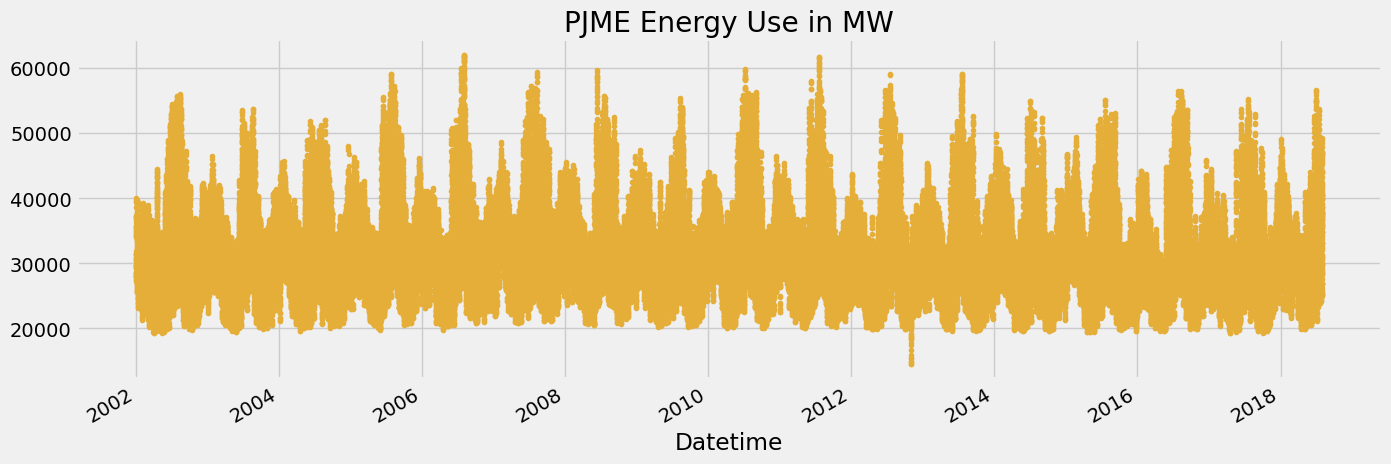

In [77]:
plt.style.use('fivethirtyeight')
clear_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[2],
        title='PJME Energy Use in MW',
        legend=False)
plt.show()

Check for outliers when MW > 60000

<Axes: xlabel='Datetime'>

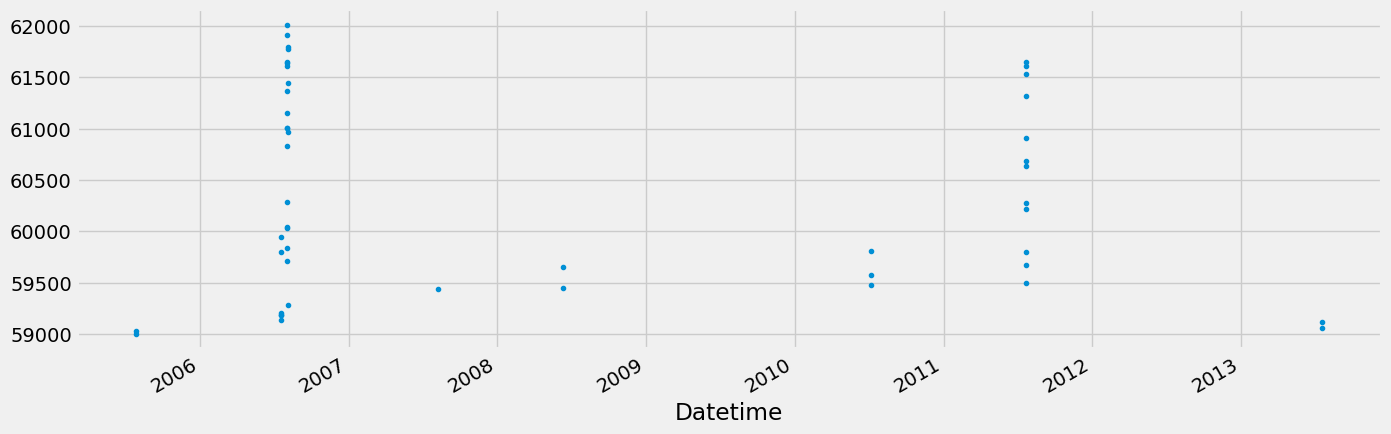

In [78]:
clear_df.query('PJME_MW > 59000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5))

Check for outliers when MW < 20000

<Axes: xlabel='Datetime'>

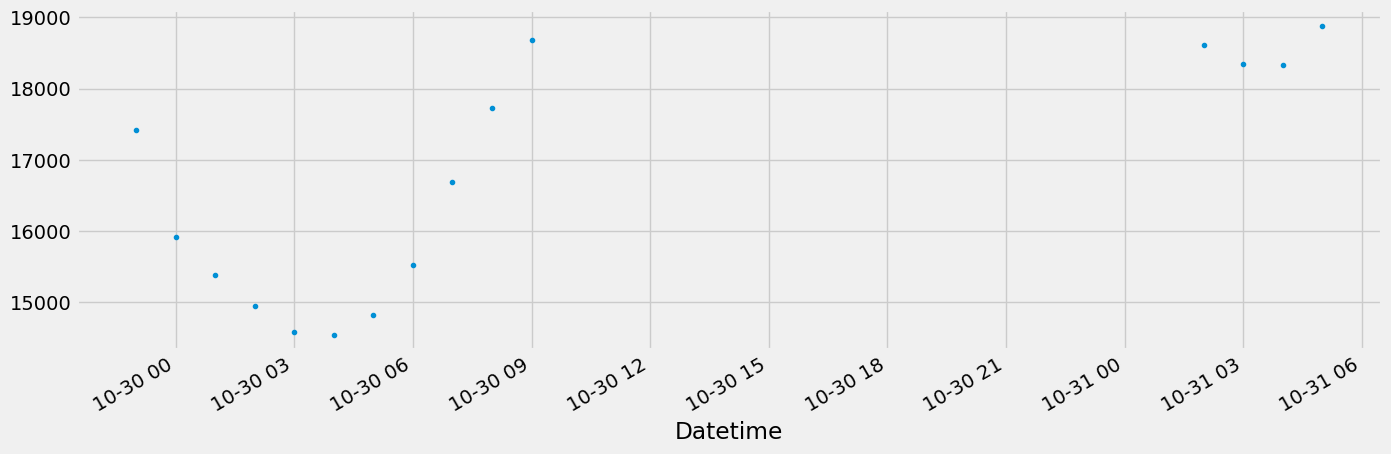

In [79]:
clear_df.query('PJME_MW < 19000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5))

Possible outliers with purple dots when MW < 19000

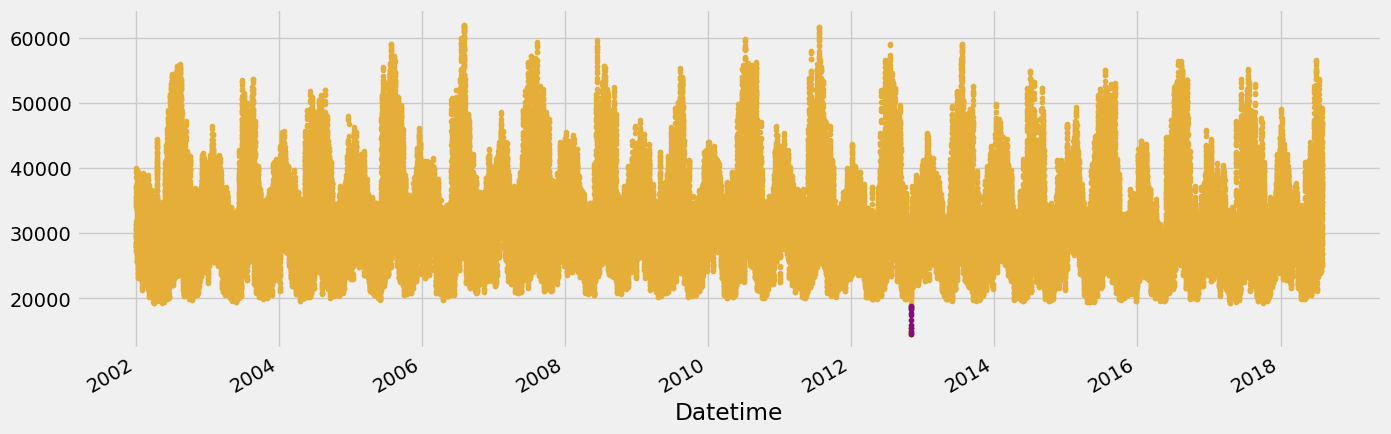

In [80]:
ax = clear_df.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[2])

clear_df.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[5],
                                             ax=ax)

ax.legend().set_visible(False)
plt.show()

Decision: Keep the outliers because they represent only 10 hours in a dataset of 145361 hours. Additionally, these 10 hours are caused by a real-life event (hurricane). We prioritize the continuity of the timeseries over the 10 hours that represent outliers.


_"On October 29–30, Hurricane Sandy brought high winds and coastal flooding to a large portion of the eastern United States, leaving an estimated 8 million customers without power. "_
https://en.wikipedia.org/wiki/List_of_major_power_outages#2012

Features creation

We will create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [81]:
def add_features(clear_df):

    clear_dff = clear_df.copy()
    clear_dff['hour'] = clear_dff.index.hour
    clear_dff['dayofweek'] = clear_dff.index.dayofweek
    clear_dff['quarter'] = clear_dff.index.quarter
    clear_dff['month'] = clear_dff.index.month
    clear_dff['year'] = clear_dff.index.year
    clear_dff['dayofyear'] = clear_dff.index.dayofyear
    clear_dff['dayofmonth'] = clear_dff.index.day
    clear_dff['weekofyear'] = clear_dff.index.isocalendar().week
    return clear_dff

df1 = add_features(clear_df)

In [82]:
df1

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31


Plot new features to search for trends

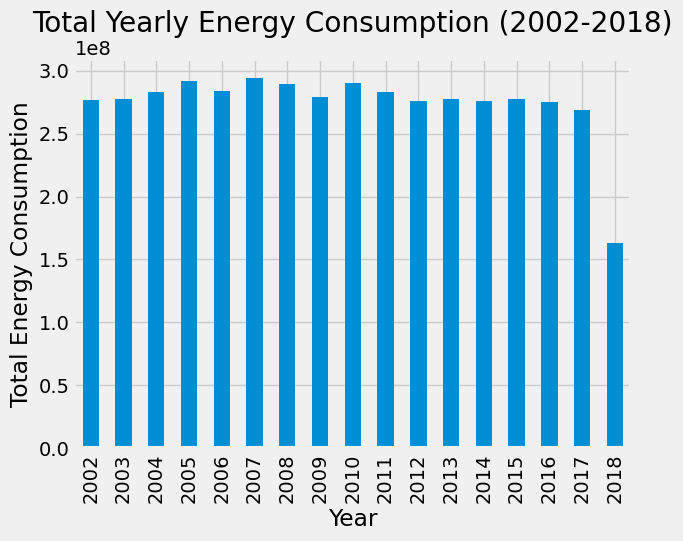

In [83]:
tyearly_energy = df1.groupby('year')['PJME_MW'].sum()
tyearly_energy.plot(kind='bar')
plt.title('Total Yearly Energy Consumption (2002-2018)')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption')
plt.show()

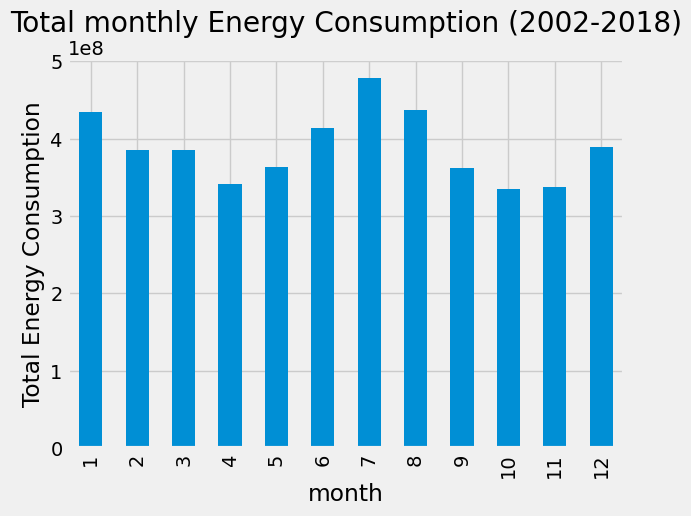

In [84]:
tmonthly_energy = df1.groupby('month')['PJME_MW'].sum()
tmonthly_energy.plot(kind='bar')
plt.title('Total monthly Energy Consumption (2002-2018)')
plt.xlabel('month')
plt.ylabel('Total Energy Consumption')
plt.show()

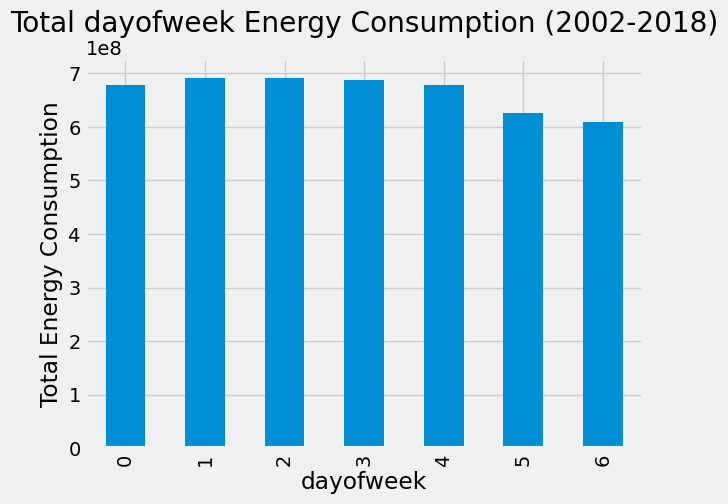

In [85]:
#0 is Monday and 6 is Sunday
tdayofweek_energy = df1.groupby('dayofweek')['PJME_MW'].sum()
tdayofweek_energy.plot(kind='bar')
plt.title('Total dayofweek Energy Consumption (2002-2018)')
plt.xlabel('dayofweek')
plt.ylabel('Total Energy Consumption')
plt.show()

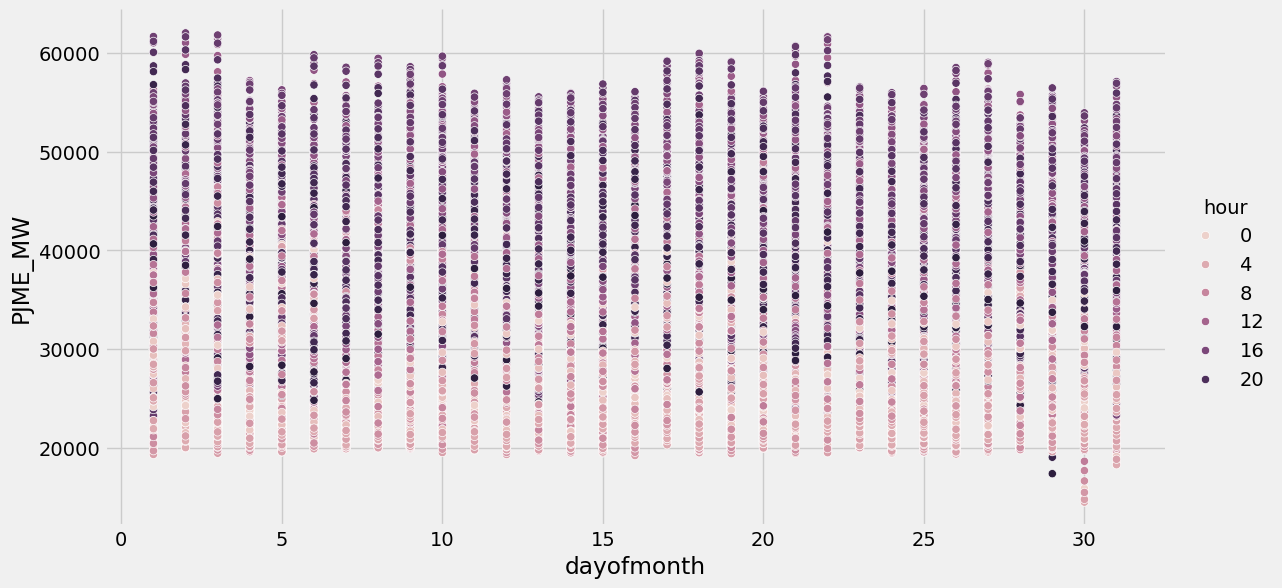

In [86]:
sns.pairplot(df1,
             hue='hour',
             x_vars=['dayofmonth'],
             y_vars='PJME_MW',
             height=6,
             aspect=2
           )
plt.show()

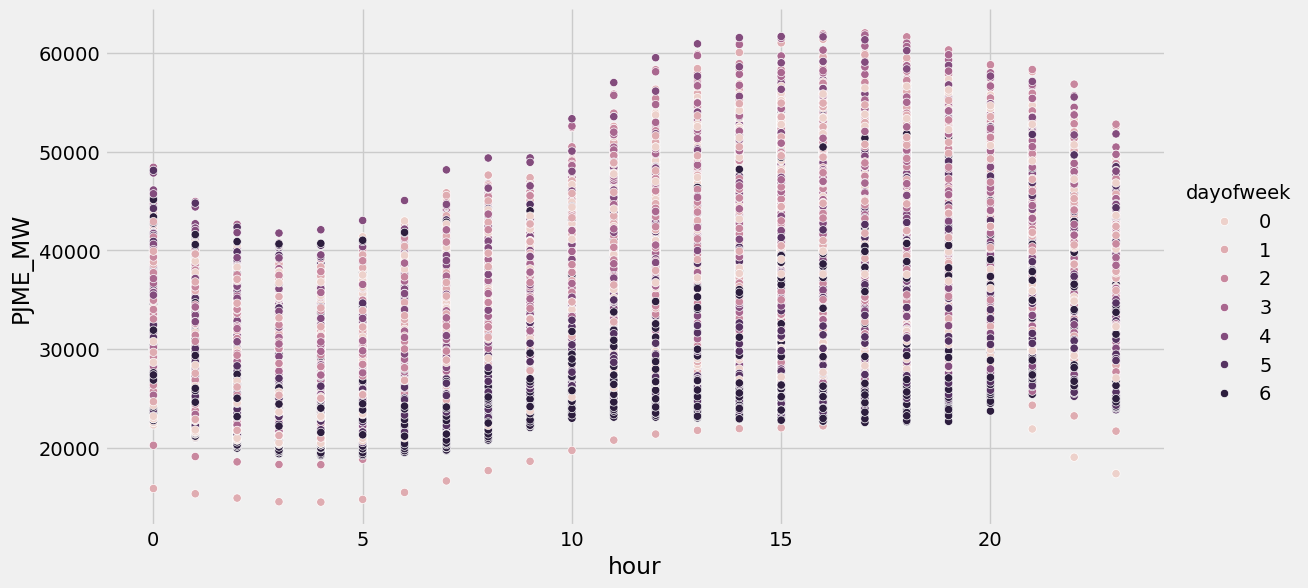

In [87]:
sns.pairplot(df1,
             hue='dayofweek',
             x_vars=['hour'],
             y_vars='PJME_MW',
             height=6,
             aspect=2
           )
plt.show()

Key findings: 

The highest Energy Consumption is during the summer. \
There doesn't seem to be a trend between days of the week or among the years. \
The daily peak Energy Consumption is around 13:00 - 19:00 in the afternoon.

## Cross Validation <a name="4"> </a>

Visualizing the training folds

In [88]:
tss = TimeSeriesSplit(n_splits = 7, test_size = 24*365*1, gap = 24)
df1 = df1.sort_index()

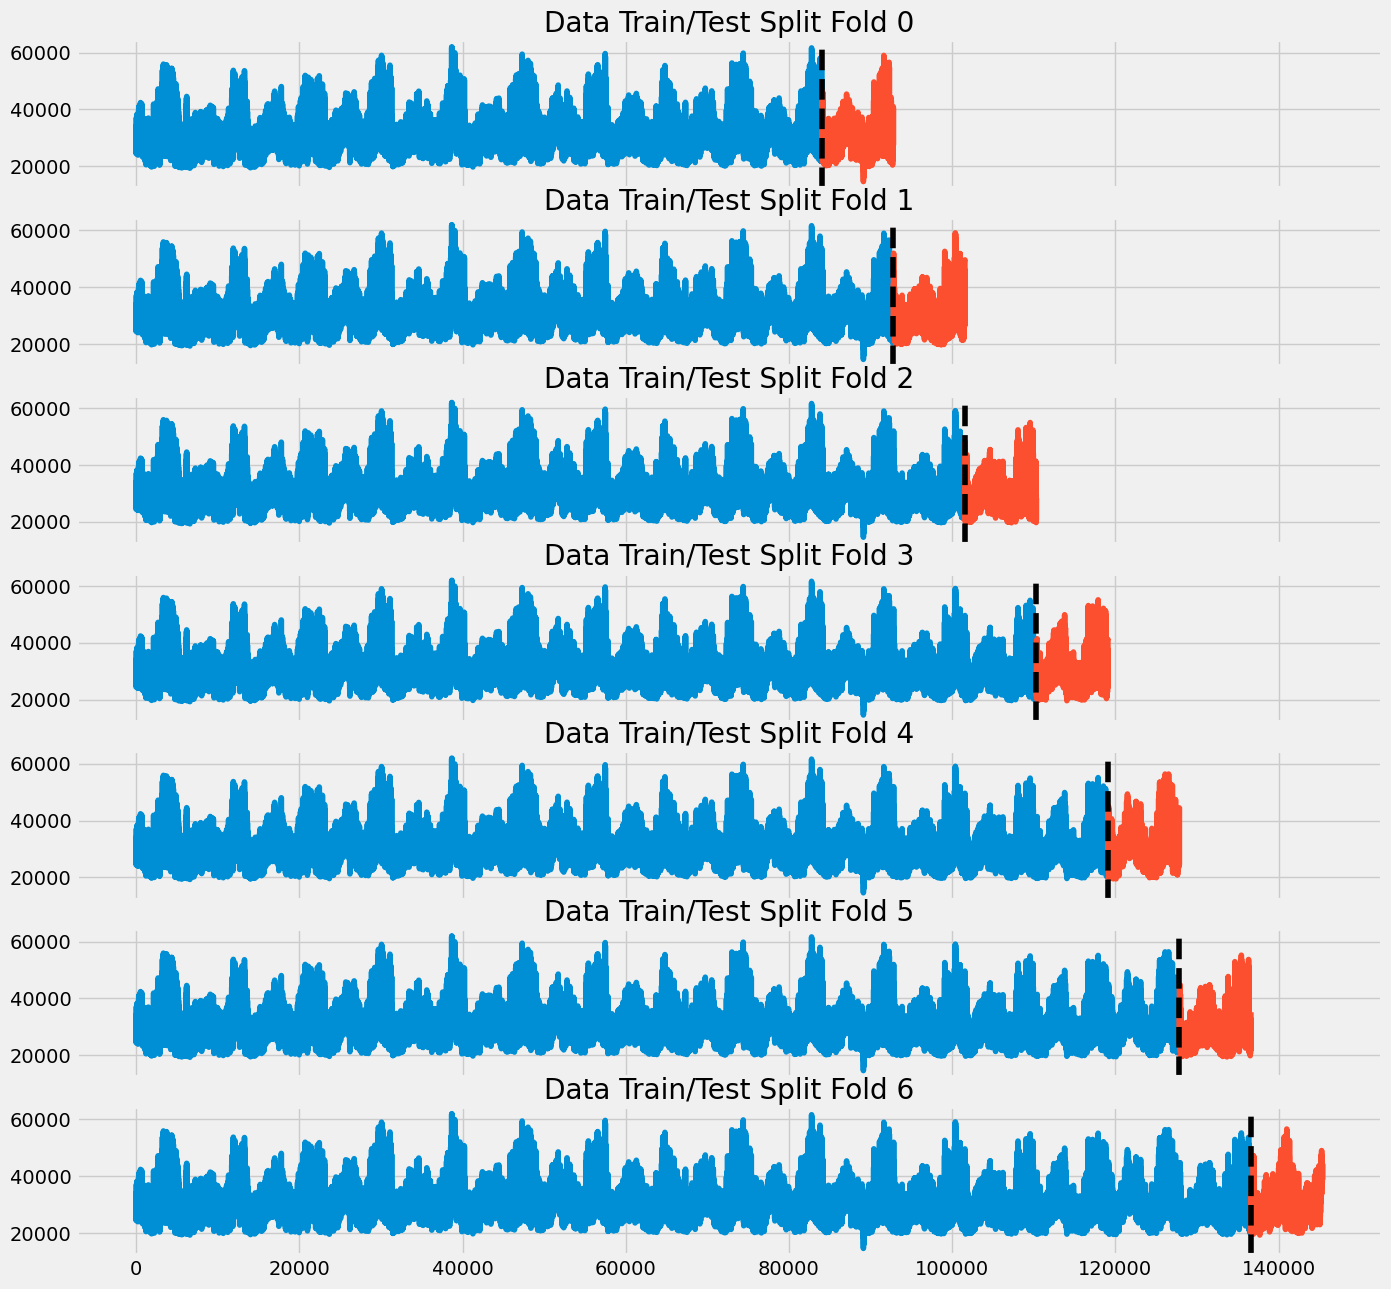

In [89]:
fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df1):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Lags


In [90]:
def add_lags(df):
    # Convert the 'PJME_MW' column to a dictionary for mapping
    target_map = df['PJME_MW'].to_dict()

    df['lag_1_year'] = (df.index - pd.Timedelta('364 days')).map(target_map)

    df['lag_7_months'] = (df.index - pd.Timedelta('210 days')).map(target_map)

    return df

In [91]:
df1 = add_lags(df1)
df1

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_7_months
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,45896.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,45377.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,44092.0


In [92]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## XGBoost <a name="5"> </a>

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

In [111]:
tss = TimeSeriesSplit(n_splits=7, test_size=24*365*1, gap=24)
df1 = df1.sort_index()


preds = []
indices = []

rmse_scores = []
mape_scores = []

for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]

    train = add_features(train)
    test = add_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'year', 'lag_1_year', 'lag_7_months', 'dayofmonth', 'weekofyear']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=5,
                           learning_rate=0.05)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)

    preds.extend(y_pred)
    indices.extend(val_idx)

    evals_result = reg.evals_result()


    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_score = mean_absolute_percentage_error(y_test, y_pred)

    rmse_scores.append(rmse_score)
    mape_scores.append(mape_score)

[0]	validation_0-rmse:31587.46698	validation_1-rmse:30380.50153
[100]	validation_0-rmse:2916.91849	validation_1-rmse:3383.05137
[109]	validation_0-rmse:2860.42909	validation_1-rmse:3423.29723
[0]	validation_0-rmse:31480.58807	validation_1-rmse:30806.60283
[100]	validation_0-rmse:2948.93435	validation_1-rmse:3501.07587
[200]	validation_0-rmse:2599.84798	validation_1-rmse:3419.51234
[300]	validation_0-rmse:2439.66739	validation_1-rmse:3366.57823
[400]	validation_0-rmse:2317.38957	validation_1-rmse:3340.98499
[492]	validation_0-rmse:2232.55895	validation_1-rmse:3330.98361
[0]	validation_0-rmse:31427.39187	validation_1-rmse:30669.10264
[100]	validation_0-rmse:2956.38599	validation_1-rmse:3638.13729
[148]	validation_0-rmse:2754.13304	validation_1-rmse:3693.91408
[0]	validation_0-rmse:31369.96315	validation_1-rmse:30856.91365
[100]	validation_0-rmse:3012.62071	validation_1-rmse:3350.91400
[200]	validation_0-rmse:2705.00014	validation_1-rmse:3250.87860
[263]	validation_0-rmse:2602.37991	valid

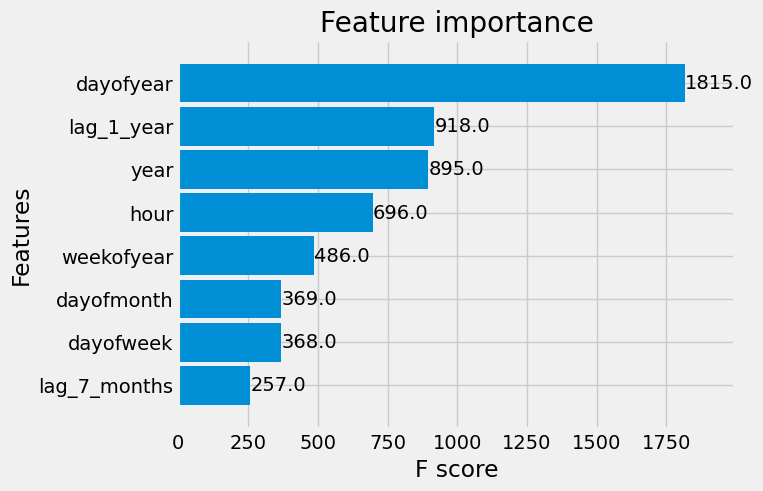

In [112]:
_ = plot_importance(reg, height=0.9)

Visualizing the traning and validation RMSE

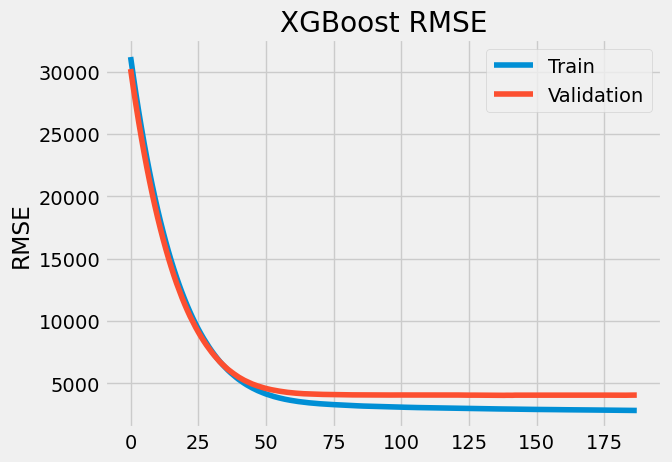

In [113]:
# Extract the rounds
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
ax.plot(x_axis, evals_result['validation_1']['rmse'], label='Validation')
ax.legend()

plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()


Calculating the RMSE and MAPE errors for each and across all folds

In [114]:
print(f'MAPE Score across folds {np.mean(mape_scores):0.4f}')
print(f'MAPE Fold scores:{mape_scores}')

MAPE Score across folds 7.9262
MAPE Fold scores:[6.47911682592485, 7.54055282484995, 8.385431440539906, 7.28589598342165, 7.946251181994132, 8.612646869961779, 9.233240226554589]


In [115]:
print(f' RMSE Score across folds {np.mean(rmse_scores):0.4f}')
print(f'RMSE Fold scores:{rmse_scores}')

 RMSE Score across folds 3479.7343
RMSE Fold scores:[2978.3439629779996, 3325.65737966817, 3620.7701189979975, 3242.35242034991, 3345.5699228901785, 3812.0389933269025, 4033.4072342759746]


Creating a dataframe with the predictions

In [98]:
preds_df = pd.DataFrame(data=preds, index=df1.iloc[indices].index, columns=['Predicted'])
preds_df

,Predicted
Datetime,
2011-08-04 15:00:00,47321.316406
2011-08-04 16:00:00,47444.570312
2011-08-04 17:00:00,47396.621094
2011-08-04 18:00:00,47396.621094
2011-08-04 19:00:00,45926.644531
...,...
2018-08-02 20:00:00,42629.445312
2018-08-02 21:00:00,41797.671875
2018-08-02 22:00:00,39699.171875


In [99]:
df1['Predicted'] = preds_df['Predicted']
df1

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_7_months,Predicted
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,45896.0,42629.445312
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,45377.0,41797.671875
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,44092.0,39699.171875


Comparing the Actual vs the Predicted PJME_MW

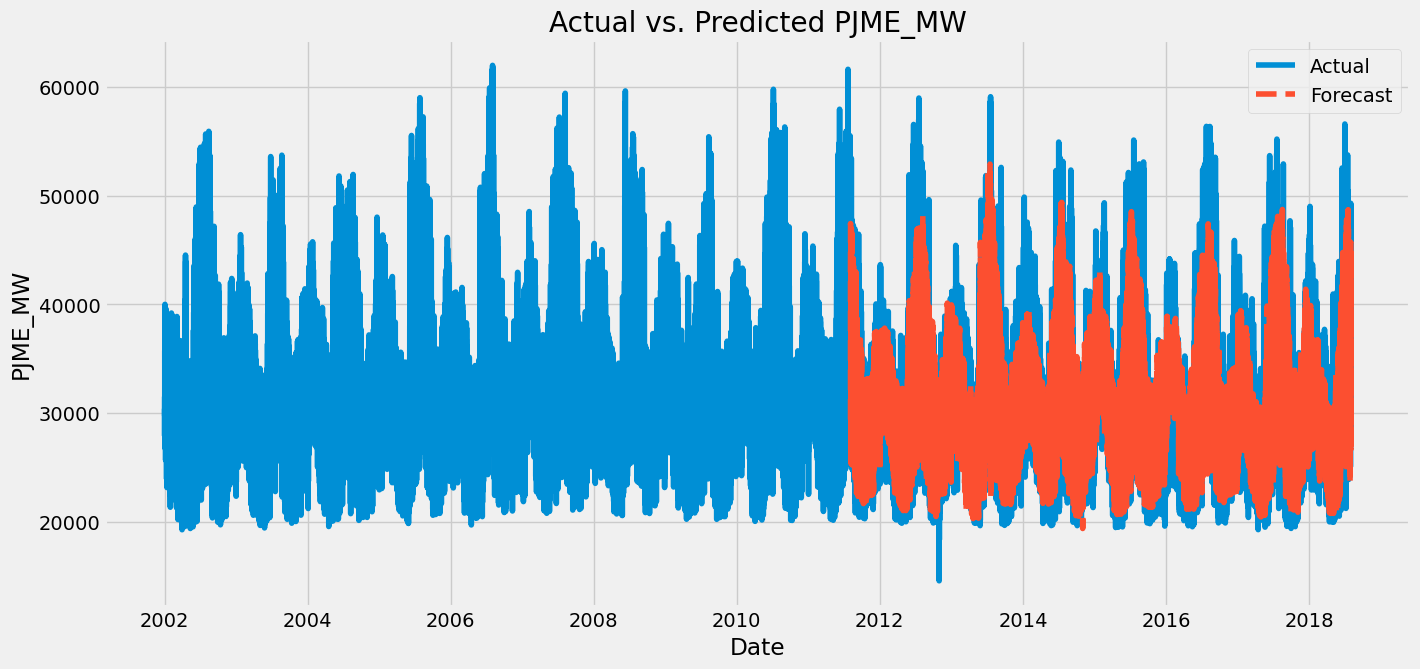

In [100]:
plt.figure(figsize=(15, 7))

# Plot the actual values
plt.plot(df1.index, df1['PJME_MW'], label='Actual')

# Plot the predicted values
plt.plot(df1.index, df1['Predicted'], label='Forecast', linestyle='--')


plt.title('Actual vs. Predicted PJME_MW')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()


plt.show()